In [ ]:
import torch
import torch.nn as nn

from datasets import load_dataset
import numpy as np
#####################
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from bart_dataset import IMDBDataset

#####################
from transformers import AdamW
from transformers import get_scheduler
from transformers import BartTokenizer, BertTokenizer
#####################
from bart_model import TestModel 
from tqdm import tqdm
#####################
from torch.optim import AdamW

In [ ]:
if torch.cuda.is_available():
    device = "cuda:2"
else:
    device = "cpu"   

device = torch.device(device)

from datasets import load_dataset

print('load imdb')
dataset = load_dataset("imdb")

In [ ]:
src_list = dict()
trg_list = dict()

train_dat = dataset['train']
test_dat = dataset['test']


print('tokenizer')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# reduce the max_length for tokenizer
tokenizer.model_max_length = 200

train_encoding = tokenizer(
    train_dat['text'][:int(0.8*len(train_dat['text']))],
    return_tensors='pt',
    padding=True,
    truncation=True
)

val_encoding = tokenizer(
    train_dat['text'][int(0.8*len(train_dat['text'])):],
    return_tensors='pt',
    padding=True,
    truncation=True
)

test_encoding = tokenizer(
    test_dat['text'],
    return_tensors='pt',
    padding=True,
    truncation=True
)

# train_len = int(len(train_dat['text']))
train_len = int(0.8*len(train_dat['text']))
val_len = int(0.2*len(train_dat['text']))
test_len = int(len(test_dat['text']))


print('dataloader')    
train_set = IMDBDataset(train_encoding, train_dat['label'][:train_len])
# train_set = IMDBDataset(train_encoding, train_dat['label'])
val_set = IMDBDataset(val_encoding, train_dat['label'][train_len:])
test_set = IMDBDataset(test_encoding, test_dat['label'])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
print("evaluate loop")        
def evaluate(model, testloader, device):
    model.to(device)
    model.eval()
    
    total_acc_test = 0

    with torch.no_grad():
        
        for i, test_input in enumerate(tqdm(testloader)):

            test_label = test_input['labels'].to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            out, _ = model(input_id, mask)

            acc = (out.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

    print('='*64)    
    print(f'Test Accuracy: {total_acc_test / test_len: .3f}')
    print('='*64)     

In [ ]:
print("evaluate")
# load model
model = TestModel()
PATH = './model.pt'
model.load_state_dict(torch.load(PATH))
evaluate(model, test_loader, device)

<h1>TSNE – Visualization of Embedding of sentences

<h2>Extract the Embedding

In [ ]:
model = TestModel()
PATH = './model.pt'
model.load_state_dict(torch.load(PATH))

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
def visualization(model, testloader, device):
    model.to(device)
    model.eval()
    data_label = pd.DataFrame(columns=['data', 'pred', 'label'])

    with torch.no_grad():

        for i, test_input in enumerate(tqdm(testloader)):

            test_label = test_input['labels'].to(device)

            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            out, outputs = model(input_id, mask)
            pred = out.argmax(dim=1)

            # append each batch by column
            mid_data = outputs.cpu().numpy()
            mid_pred = pred.cpu().numpy()
            mid_label = test_label.cpu().numpy()

            for i in range(len(mid_data)):
                data_label = data_label.append({'data': mid_data[i], 'pred': mid_pred[i],'label': mid_label[i]}, ignore_index=True)

    return data_label


In [ ]:
data_label = visualization(model, test_loader, device)

In [ ]:
# prediction function for meshgrid
def prediction():

In [ ]:
test_label = data_label['label']
test_data = data_label['data']
test_pred = data_label['pred']

<h2>TSNE

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

sentence_embedded = np.array(test_data.tolist())
X = sentence_embedded[:1000]

X_embedded = TSNE(n_components=2).fit_transform(X)

In [ ]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=test_label[:1000].values)
df_embeddings = df_embeddings.assign(pred=test_pred[:1000].values)

df_embeddings = df_embeddings.assign(text=test_data[:1000].values)

<h2> display embedding

In [ ]:
!pip install plotly

In [ ]:
!pip install "notebook>=5.3" "ipywidgets>=7.2"

In [ ]:
import plotly.express as px


In [ ]:

fig = px.scatter(df_embeddings, x='x', y='y',
                 color='label', labels={'color': 'label'},
                 hover_data=['text'], title = 'IMDB Embedding Visualization',
                 width=1000, height=1000)
fig.show()

In [ ]:
fig = px.scatter(df_embeddings, x='x', y='y',
                 color='pred', labels={'color': 'pred'},
                 hover_data=['text'], title = 'IMDB Embedding Prediction Visualization',
                 height=1000, width=1000)
fig.show()

In [ ]:
# check size of df_embeddings
df_embeddings.shape

In [44]:
df_embeddings['x']

0     -10.292034
1      10.570462
2      -6.810357
3      -3.159194
4      -0.011285
         ...    
995    11.200824
996    14.037223
997    -2.295914
998    15.814810
999     3.721992
Name: x, Length: 1000, dtype: float32

In [26]:
import matplotlib.pyplot as plt

In [43]:
# visualization for bert model
# df_embeddings
x_min, x_max = df_embeddings['x'][:].min() - .5, df_embeddings['x'][:].max() + .5
y_min, y_max = df_embeddings['y'][:].min() - .5, df_embeddings['y'][:].max() + .5
h = 0.05

# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.vstack([xx.ravel(), yy.ravel()]).T

# transfer from pred to Predict the function value for the whole gid
pred = df_embeddings['pred'][:].values
zz = pred.reshape(xx.shape)



ValueError: cannot reshape array of size 1000 into shape (1856,801)

In [42]:
zz = pred.reshape(xx.shape)

ValueError: cannot reshape array of size 1000 into shape (1856,801)

TypeError: Input z must be 2D, not 1D

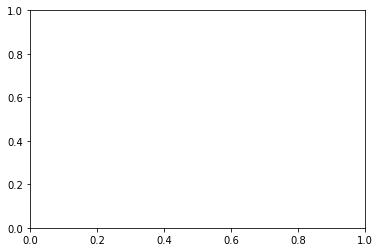

In [29]:
# Plot the contour and training examples
plt.contourf(xx, yy, pred)
plt.scatter(df_embeddings['x'][:], df_embeddings['y'][:], c=df_embeddings['label'][:].values , s=40, edgecolors="grey", alpha=0.9)

In [30]:
import matplotlib.tri as tri
import numpy as np
npts = 100
x = np.random.uniform(-2, 2, npts)
y = np.random.uniform(-2, 2, npts)
z = x * np.exp(-x**2 - y**2)
ngridx = 100
ngridy = 100
xi = np.linspace(-2.2, 2.2, ngridx)
yi = np.linspace(-2.2, 2.2, ngridy)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

In [37]:
zi.shape

(100, 100)

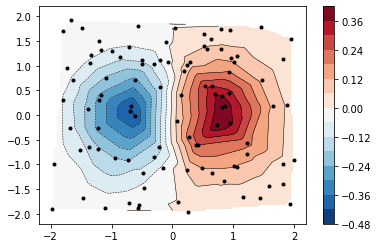

In [31]:
plt.contour(xi, yi, zi, levels=15, linewidths=0.5, colors='k')
cntr = plt.contourf(xi, yi, zi, levels=15, cmap="RdBu_r")
plt.colorbar(cntr)
plt.plot(x, y, 'ko', ms=3)
plt.show()